## **NLP: Spam-Ham Classifier**

*A Machine Learning Classifier to Classify whether the Message is Spam or Ham using Natural Language Processing(NLP)*

Introduction: 

- Spam/Ham detection is a classic challenge where classification algorithms have played a crucial role for many years. Spam messages, often filled with irrelevant or harmful content, inundate inboxes daily, posing a significant distraction to users. Efficient detection and prevention of these messages are essential to maintaining productivity and security.

- Google, among other tech companies, has excelled in combating spam through the use of AI-driven solutions. While Google's methods are highly effective, understanding the steps leading to automation in spam detection can provide valuable insights into the underlying principles and techniques.

- Objective of this project is to build a classifier that help us differentiate between spam and non-spam (ham) messages more accurately.

In [7]:
# Import libraries for reading data, exploring and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string

import re

# Import Machine Learning libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Import NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, ne_chunk

In [8]:
# Mounting the Google Drive to the Colab notebook

from google.colab import drive 
drive.mount('/content/drive')

In [9]:
# Loading the SMS spam collection dataset from Google Drive into a DataFrame

data = pd.read_csv('/content/drive/MyDrive/SMSSpamCollection', sep='\t', header=None)

In [10]:
# Create a copy of the DataFrame 'data' and assign it to a new variable 'df'

df = data.copy()

In [11]:
# Display the first few rows of the DataFrame to preview its structure

df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Rename the column names**

In [12]:
# 'Label' is assigned to the column at index 0, and 'Message' is assigned to the column at index 1.

df.rename(columns={0: 'Label', 1: 'Message'}, inplace=True)

#### **Exploratory Data Analysis**

In [13]:
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
# Display concise summary information about the DataFrame 'df', including column names, data types, non-null counts, and memory usage.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [15]:
# Generate descriptive statistics of the DataFrame 'df'.

df.describe()

,Label,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


**Insights**
- Label Distribution: *The dataset contains a total of 5,572 entries. Among these, the majority (4,825) are labeled as 'ham', indicating non-spam messages, while the remaining 747 entries are labeled as 'spam'. This suggests an imbalance in the dataset, with 'ham' messages being significantly more prevalent.*

- Message Variability: *There are 5,169 unique messages in the dataset, indicating wide variety of text content. However, some messages are repeated, with the most frequent message being - "Sorry, I'll call later", occuring 30 times.*

- Task Objective: *The task of sentiment analysis or spam detection involves predicting the label ('ham' or 'spam') for each message based on its content.*

In [16]:
# Group the DataFrame 'df' by the 'Label' column and generate descriptive statistics for each group.

df.groupby('Label').describe()

Message                                                               
        count unique                                                top freq
Label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

- *Out of the 5,572 messages in the dataset, 4,825 are categorized as 'ham' (non-spam), with 4,516 unique messages.*

- *Conversely, there are 747 spam messages, out of which 653 are unique.*

In [17]:
# Counting Message Occurrences and Calculating Dense Ranks for Top 5 Messages

message_counts = df['Message'].value_counts().reset_index().sort_values(by='count', ascending=False)

# Calculating the Dense ranks for the top 5 messages
message_counts['Rank'] = message_counts['count'].rank(method='dense', ascending=False).astype('int')

message_counts[message_counts['Rank'] <= 5]

,Message,count,Rank
0,"Sorry, I'll call later",30,1
1,I cant pick the phone right now. Pls send a me...,12,2
2,Ok...,10,3
7,"Wen ur lovable bcums angry wid u, dnt take it ...",4,4
10,Ok,4,4
...,...,...,...
31,"Sorry, I can't help you on this.",3,5
28,Ok.ok ok..then..whats ur todays plan,3,5
27,"She said,'' do u mind if I go into the bedroom...",3,5
29,Wife.how she knew the time of murder exactly,3,5


**Let's create a new feature to capture the length of text messages.**

In [18]:
df['Txt_length'] = df['Message'].apply(len)
df.head()

,Label,Message,Txt_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [19]:
# Function to count the total number of punctuation marks in a text

def find_punct(text):
  count = 0

  for char in text:
    if char in string.punctuation:
      count += 1

  return count


df['Total_Punct'] = df['Message'].apply(lambda x: find_punct(x))

In [20]:
df.head()

,Label,Message,Txt_length,Total_Punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


**Assign String DataType to the Message Column**

In [21]:
df['Message'] = df['Message'].astype(str)

#### **Analyzing the difference between Spam and Ham messages**

In [22]:
# Extract spam messages from the DataFrame
spam_messages = df[df['Label'] == 'spam']

# Extract ham messages from the DataFrame
ham_messages = df[df['Label'] == 'ham']

In [23]:
print(f"Spam Message Punctuation Mean: {spam_messages['Total_Punct'].mean()}")

print(f"Ham Message Punctuation Mean: {ham_messages['Total_Punct'].mean()}")

Spam Message Punctuation Mean: 5.712182061579652
Ham Message Punctuation Mean: 3.9398963730569947


In [24]:
print(f"Spam Message Length Mean: {spam_messages['Txt_length'].mean()}")

print(f"Ham Message Length Mean: {ham_messages['Txt_length'].mean()}")

Spam Message Length Mean: 138.6706827309237
Ham Message Length Mean: 71.48248704663213


**Punctuation Usage:** On average, Spam messages exhibit a higher punctuation count compared to ham messages, with a mean punctuation count of approximately **5.71** for spam messages and **3.94** for ham messages.

*This suggest that spam messages tend to contain more punctuation marks, possibly to grab attention or create urgency*

**Message Length:** Additionalyy, Spam messages are longer on average compared to ham messages, with a mean length of approximately **138** characters for spam messages and **71** characters for ham messages.

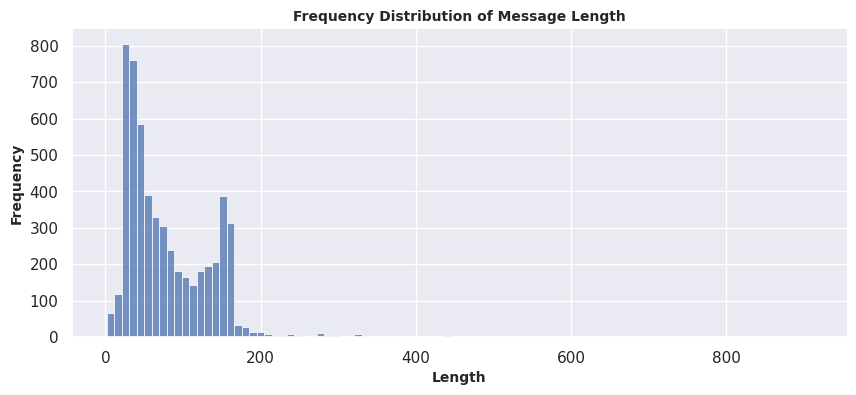

In [25]:
# Visualizing the Frequency Distribution of message length

sns.set_theme(style='darkgrid')
plt.figure(figsize=(10, 4))
sns.histplot(x=df['Txt_length'])

plt.title('Frequency Distribution of Message Length', fontdict={'weight': 'bold', 'fontsize': 10})
plt.xlabel('Length', fontdict={'weight': 'bold', 'fontsize': 10})
plt.ylabel('Frequency', fontdict={'weight': 'bold', 'fontsize': 10})

sns.despine()
plt.show()

*Many messages have a length of less than 200 characters. However, it's worth noting that the x-axis extends to around 1,000 indicating the presence of some exceptionally long messages.*

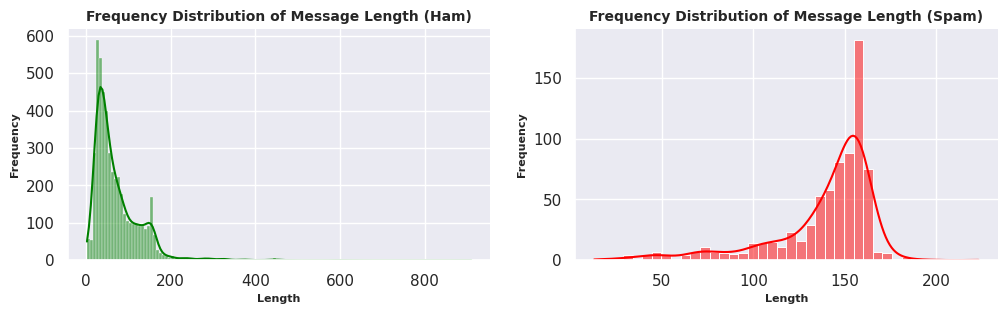

In [26]:
# Frequency Distribution of message length for Ham and Spam

# Set up the plot
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12, 3))

# Plot histogram for Ham messages
plt.subplot(1, 2, 1)
sns.histplot(x=ham_messages['Txt_length'], color='green', kde=True)
plt.title('Frequency Distribution of Message Length (Ham)', fontdict={'weight': 'bold', 'fontsize': 10})
plt.xlabel('Length', fontdict={'weight': 'bold', 'fontsize': 8})
plt.ylabel('Frequency', fontdict={'weight': 'bold', 'fontsize': 8})

# Plot histogram for Spam messages
plt.subplot(1, 2, 2)
sns.histplot(x=spam_messages['Txt_length'], color='red', kde=True)
plt.title('Frequency Distribution of Message Length (Spam)', fontdict={'weight': 'bold', 'fontsize': 10})
plt.xlabel('Length', fontdict={'weight': 'bold', 'fontsize': 8})
plt.ylabel('Frequency', fontdict={'weight': 'bold', 'fontsize': 8})

sns.despine()
plt.show()

*It appears that there's a trend where spam messages tend to be longer than ham messages.*

#### **Visualizing the Distribution of Target Variable - Spam OR Ham**

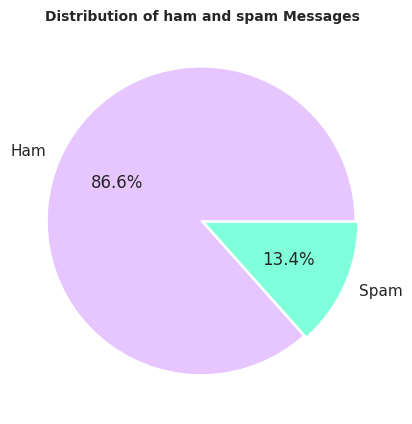

In [27]:
# Visualizing the Distribution of Target Variable - Spam OR Ham

plt.figure(figsize=(5, 5))
plt.pie(df['Label'].value_counts(), labels=['Ham', 'Spam'], colors=['#e7c6ff', '#80ffdb'], autopct='%1.1f%%', explode=(0.01, 0.01))
plt.title('Distribution of ham and spam Messages', fontdict={'weight': 'bold', 'fontsize': 10})

plt.show()

*Now, let's further explore the imbalanced data. The pie chart clearly illustrates the class distribution imbalance, with the majority being ham messages (86%) and a minority being spam messages (13%).*

In [28]:
df.drop(columns=['Txt_length', 'Total_Punct'], inplace=True)

### **Text Pre-Processing**

To enable machines to process text effectively, we often convert textual data into numerical form. However, before this conversion, it's essential to clean the data. Data cleaning involves removing unnecessary punctuations and numbers, standardizing the text to either lower or upper case, and eliminating irrelevant white spaces

Creating a custom function to perform data cleaning

Clean the text data by performing the following operations:
- Convert text to lowercase.
- Remove HTML line break tags '(br)'.
- Replace certain punctuation marks with spaces.
- Remove other punctuation marks and special characters.
- Replace multiple consecutive spaces with a single space.
- Strip leading and trailing whitespaces.

In [32]:
def clean_text(text):

  text = text.lower().strip()
  text = re.sub(r'<br>', '', text)
  text = re.sub(r"([-?.!,/\"])", r" \1 ", text)
  text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,']", "", text)
  text = re.sub(r"[ ]+", " ", text)
  text = text.rstrip().strip()

  return text

In [35]:
df['Message'] = df['Message'].astype(str)

In [36]:
df['clean_msg'] = df['Message'].apply(lambda x: clean_text(x))
df.head()

,Label,Message,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


**1. Tokenization**

Tokenizing separates text into units such as sentences or words. It gives structure to previously unstructured text. eg: Plata o Plomo-> ‘Plata’,’o’,’Plomo’.

In [41]:
df['clean_msg'] = df['clean_msg'].astype(str)

In [42]:
df['MSG_Tokenized'] = df['clean_msg'].apply(lambda x: word_tokenize(x))

df.head()

,Label,Message,clean_msg,MSG_Tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


**2. Remove Punctuation***

Punctuation can provide grammatical context to a sentence which supports our understanding. However for our vectorizer which counts the number of words and not the context, it does not add value, So we remove all special characteres.

In [43]:
# Function to remove punctuation

def remove_punct(text):
    cld_txt = "".join(char for char in text if char not in string.punctuation)
    return cld_txt

df['MSG_Tokenized'] = df['MSG_Tokenized'].apply(lambda words: [remove_punct(word) for word in words])

df.head()

,Label,Message,clean_msg,MSG_Tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


In [44]:
# Function to remove non-alphabetic characters
def remove_non_alpha(text):
    cleaned_text = "".join(char for char in text if char.isalpha())
    return cleaned_text

# Apply the function to each tokenized message and remove non-alphabetic characters
df['MSG_Tokenized'] = df['MSG_Tokenized'].apply(lambda words: [remove_non_alpha(word) for word in words])
df.head(4)

,Label,Message,clean_msg,MSG_Tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, , a, wkly, comp, to, win, fa..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."


**3. Remove Stopwords**

Stopwords are common words that will likely appear in any text. They don’t tell us much about our data so we remove them. eg: silver or lead is fine for me-> silver, lead, fine.

In [47]:
# Function to remove stopwords

def remove_stopwords(text):

    from nltk.corpus import stopwords
    stopwords = set(stopwords.words('english'))

    text = [word for word in text if word not in stopwords]
    return text

df['MSG_nonstop'] = df['MSG_Tokenized'].apply(lambda x: remove_stopwords(x))

df.head()

,Label,Message,clean_msg,MSG_Tokenized,MSG_nonstop
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, , a, wkly, comp, to, win, fa...","[free, entry, , wkly, comp, win, fa, cup, fina..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."


In [48]:
# Remove empty strings from the list of tokens

def remove_empty_string(text):

    text = [token for token in text if token]
    return text

df['MSG_nonstop'] = df['MSG_nonstop'].apply(lambda x: remove_empty_string(x))

In [49]:
df.head()

,Label,Message,clean_msg,MSG_Tokenized,MSG_nonstop
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, , a, wkly, comp, to, win, fa...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."


**Let's delve deeper into the data by analyzing ham and spam messages separately. We'll create separate DataFrames for each label group to generate WordClouds.**

In [50]:
# Extract all the ham and spam emails

df_cld = df.copy()
df_cld['MSG_nonstop'] = df_cld['MSG_nonstop'].apply(lambda x: ' '.join(x))

ham_msg = df_cld[df_cld['Label'] == 'ham']['MSG_nonstop']
spam_msg = df_cld[df_cld['Label'] == 'spam']['MSG_nonstop']

# Combine ham messages into a single string
ham_msg_txt = ' '.join(ham_msg)

# Combine spam messages into a single string
spam_msg_txt = ' '.join(spam_msg)

**Wordcloud for Ham Message**

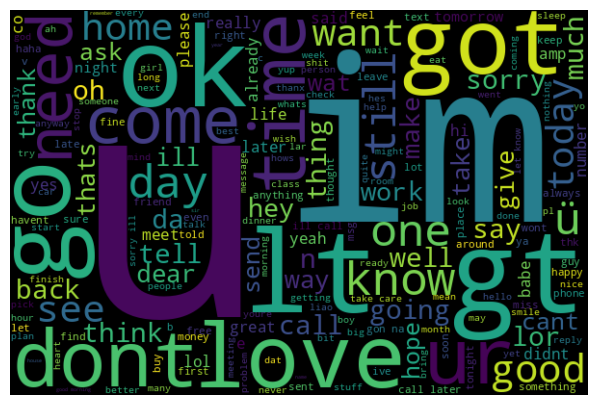

In [51]:
ham_msg_cloud = WordCloud(width=600, height=400, background_color='black').generate(ham_msg_txt)
plt.figure(figsize=(10, 5))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Wordcloud of Spam Message**

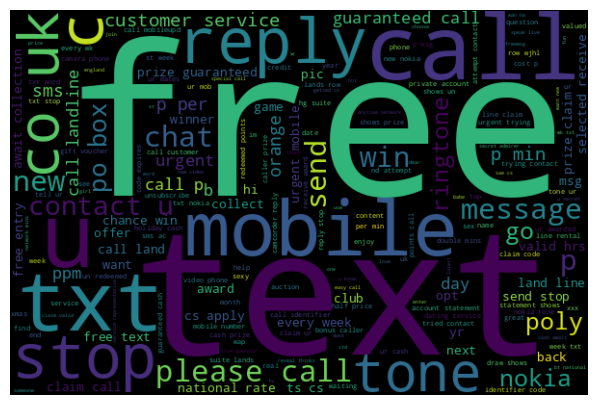

In [52]:
spam_msg_cloud = WordCloud(width=600, height=400, background_color='black').generate(spam_msg_txt)
plt.figure(figsize=(10, 5))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- Most frequently used words in 'Ham' messages are ['got', 'love', 'go', 'call', 'ok', 'time', 'come', 'know', 'need', 'going', 'think']

- Most frequently used words in 'Spam' messages are ['free', 'call', 'reply', 'urgent', 'win', 'prize', 'claim', 'Guaranteed', 'please call', 'call now']

#### **Text Normalization: Stemming**

- Stemming a word means to reduce that word to its base form. Like reduce goes, going, gone to go. We do stemming to reduce unncessary crowding of words (there will be no additional information from goes, going or gone. All can be reduced to go and will still provide same information)

In [53]:
# Function to perform stemming

def stemming(text):

    stemmer = PorterStemmer()

    text = [stemmer.stem(word) for word in text]
    return text

# Apply stemming to each entry in the 'MSG_nonstop' column

df['MSG_Stem'] = df['MSG_nonstop'].apply(lambda x: stemming(x))

df.head()

,Label,Message,clean_msg,MSG_Tokenized,MSG_nonstop,MSG_Stem
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, , a, wkly, comp, to, win, fa...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."


#### **Data Normalization: Lemmatization**

- Lemmatization works same as stemming but the only difference is that with stemming we occasionally end up with base/root words which do not provide any semantic meaning. like history becomes histori which has no meaning in English vernacular. Lemmatization preserves the semantic meaning and hence is preferred over stemming in many applications where the meaning of the words are of much importance. However, stemming is done most of the times when dataset is large as lemmatization takes a lot of time to process. Stemming is quite fast.

In [58]:
# Function to perform lemmatization
def lemmatizing(text):

    lemmatizer = WordNetLemmatizer()

    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# Apply lemmatization to each entry in the 'MSG_nonstop' column

df['MSG_Lemmt'] = df['MSG_nonstop'].apply(lambda x: lemmatizing(x))

df.head()

,Label,Message,clean_msg,MSG_Tokenized,MSG_nonstop,MSG_Stem,MSG_Lemmt
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, , a, wkly, comp, to, win, fa...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...","[nah, dont, think, go, usf, life, around, though]"


In [59]:
# Create a new DataFrame containing only the 'MSG_Lemmt' and 'Label' columns

ndf = df[['MSG_Lemmt', 'Label']]

In [60]:
# Concatenate the list of lemmatized words into a single string for each row

ndf['MSG_Lemmt'] = [' '.join(word) for word in ndf['MSG_Lemmt']]

<ipython-input-60-e3360edae9df>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['MSG_Lemmt'] = [' '.join(word) for word in ndf['MSG_Lemmt']]


In [61]:
ndf.head()

,MSG_Lemmt,Label
0,go jurong point crazy available bugis n great ...,ham
1,ok lar joking wif u oni,ham
2,free entry wkly comp win fa cup final tkts st ...,spam
3,u dun say early hor u c already say,ham
4,nah dont think go usf life around though,ham


In [62]:
# Check for null values
ndf.isna().sum()

MSG_Lemmt    0
Label        1
dtype: int64

In [63]:
# Drop rows with NaN values in the DataFrame
ndf.dropna(inplace=True)

# Check if there are any NaN values after dropping
ndf.isna().sum()

<ipython-input-63-cecf38c0b6a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf.dropna(inplace=True)


MSG_Lemmt    0
Label        0
dtype: int64

**Splitting the Data into X & Y**

In [64]:
X = ndf['MSG_Lemmt']
Y = ndf['Label']

**Splitting the Data into Training and Testing**

In [65]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=4)

print(f'The Shape of Xtrain: {xtrain.shape}')
print(f'The Shape of Xtest: {xtest.shape}')
print(f'The Shape of Ytrain: {ytrain.shape}')
print(f'The Shape of Ytest: {ytest.shape}')

The Shape of Xtrain: (4457,)
The Shape of Xtest: (1115,)
The Shape of Ytrain: (4457,)
The Shape of Ytest: (1115,)


**Vectorizing Data: TF-IDF**

- Vectorizing is the process of converting textual data into numerical representations, typically in the form of feature vectors. This encoding enables machine learning algorithms to comprehend and process the data effectively. By assigning numeric values to words or tokens, vectorization facilitates the transformation of text-based information into a format that can be utilized for training and prediction tasks within machine learning models.

In [66]:
# Initialize the TF-IDF vectorizer
tfidf_vec = TfidfVectorizer()

In [67]:
# Transforming the training data into TF-IDF representation
xtrain_tfidf = tfidf_vec.fit_transform(xtrain)

# Transforming the test data using the same TF-IDF vectorizer as the training data
xtest_tfidf = tfidf_vec.transform(xtest)

In [68]:
# Print the shapes
print(f'The Shape of Xtrain TF-IDF: {xtrain_tfidf.shape}')
print(f'The Shape of Xtest TF-IDF: {xtest_tfidf.shape}')

The Shape of Xtrain TF-IDF: (4457, 6505)
The Shape of Xtest TF-IDF: (1115, 6505)


In [69]:
xtrain_tfidf = xtrain_tfidf.toarray()
xtest_tfidf = xtest_tfidf.toarray()

In [70]:
xtrain_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### **Model Building and Model Architecture**

---



- We have to convert categorical labels to numeric format for compatibility with algorithms like XGBoost. Label encoding assigns unique integers to each category, enabling model training without error.

In [71]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert categorical labels to numerical format
ytrain_encoded = label_encoder.fit_transform(ytrain)
ytest_encoded = label_encoder.transform(ytest)

**LogisticRegression Classifier**

In [72]:
# Initialize the Logistic Regression classifier
logistic_model = LogisticRegression()

# Train the classifier on the training data
logistic_model.fit(xtrain_tfidf, ytrain_encoded)

# Prediction on the train and test data
train_pred_lg = logistic_model.predict(xtrain_tfidf)
test_pred_lg = logistic_model.predict(xtest_tfidf)

# Evaluate the accuracy of the classifier
train_accuracy = metrics.accuracy_score(ytrain_encoded, train_pred_lg)
test_accuracy = metrics.accuracy_score(ytest_encoded, test_pred_lg)

print(f"Training Accuracy: {np.round(train_accuracy, 3)*100} %")
print(f"Testing Accuracy: {np.round(test_accuracy, 3)*100} %")

Training Accuracy: 97.0 %
Testing Accuracy: 96.1 %


In [73]:
# Print classification report for Training
print("Classification Report For Training:")
print(f"{metrics.classification_report(ytrain_encoded, train_pred_lg)}\n")

# Print classification report for Testing
print("Classification Report For Testing:")
print(metrics.classification_report(ytest_encoded, test_pred_lg))

Classification Report For Training:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3878
           1       0.99      0.78      0.87       579

    accuracy                           0.97      4457
   macro avg       0.98      0.89      0.93      4457
weighted avg       0.97      0.97      0.97      4457


Classification Report For Testing:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       947
           1       1.00      0.74      0.85       168

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.96      0.96      0.96      1115



**Multinomial Naive Bayes.**

---



In [74]:
# Initialize the Naive Bayes classifier
NB_model = MultinomialNB()

# Train the classifier on the training data
NB_model.fit(xtrain_tfidf, ytrain_encoded)

# Prediction on the train and test data
train_pred_nb = NB_model.predict(xtrain_tfidf)
test_pred_nb = NB_model.predict(xtest_tfidf)

# Evaluate the accuracy of the classifier
train_accuracy_nb = metrics.accuracy_score(ytrain_encoded, train_pred_nb)
test_accuracy_nb = metrics.accuracy_score(ytest_encoded, test_pred_nb)

print(f"Training Accuracy: {np.round(train_accuracy_nb, 3)*100} %")
print(f"Testing Accuracy: {np.round(test_accuracy_nb, 2)*100} %")

Training Accuracy: 97.8 %
Testing Accuracy: 95.0 %


In [75]:
# Print classification report for Training
print("Classification Report For Training:")
print(f"{metrics.classification_report(ytrain_encoded, train_pred_nb)}\n")

# Print classification report for Testing
print("Classification Report For Testing:")
print(metrics.classification_report(ytest_encoded, test_pred_nb))

Classification Report For Training:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3878
           1       1.00      0.83      0.91       579

    accuracy                           0.98      4457
   macro avg       0.99      0.92      0.95      4457
weighted avg       0.98      0.98      0.98      4457


Classification Report For Testing:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       947
           1       0.99      0.70      0.82       168

    accuracy                           0.95      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.95      0.95      1115



**XGB Classifier**

---



In [76]:
# Initialize the Naive Bayes classifier
XGB_model = XGBClassifier()

# Define hyperparameter grid for Grid Search
params = {
    'max_depth': [2, 5, 10],
    'n_estimators': [300, 500]
}

# Create a GridSearchCV object with the XGBoost model
grid_search_xgb = GridSearchCV(XGB_model, param_grid=params)

# Train the classifier on the training data
grid_search_xgb.fit(xtrain_tfidf, ytrain_encoded)

best_xgb_model = grid_search_xgb.best_estimator_

# Prediction on the train and test data
x_pred_encoded = best_xgb_model.predict(xtrain_tfidf)
Y_pred_encoded = best_xgb_model.predict(xtest_tfidf)

# Evaluate the accuracy of the classifier
train_accuracy = metrics.accuracy_score(ytrain_encoded, x_pred_encoded)
test_accuracy = metrics.accuracy_score(ytest_encoded, Y_pred_encoded)

print(f"Training Accuracy: {np.round(train_accuracy, 3)*100} %")
print(f"Testing Accuracy: {np.round(test_accuracy, 3)*100} %")


Training Accuracy: 99.1 %
Testing Accuracy: 97.7 %


In [77]:
best_xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [78]:
# Print classification report for Training
print("Classification Report For Training:")
print(f"{metrics.classification_report(ytrain_encoded, x_pred_encoded)}\n")

# Print classification report for Testing
print("Classification Report For Testing:")
print(metrics.classification_report(ytest_encoded, Y_pred_encoded))


Classification Report For Training:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3878
           1       1.00      0.93      0.97       579

    accuracy                           0.99      4457
   macro avg       1.00      0.97      0.98      4457
weighted avg       0.99      0.99      0.99      4457


Classification Report For Testing:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       947
           1       0.97      0.87      0.92       168

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



**Support Vector Machine (Classifier)**

---



In [82]:
# Initialize the Support Vector Classifier
svc_model = SVC()

# Train the Support Vector Classifier on the training data
svc_model.fit(xtrain_tfidf, ytrain_encoded)

# Predict the labels for the train and test data using SVC
train_pred_svc = svc_model.predict(xtrain_tfidf)
test_pred_svc = svc_model.predict(xtest_tfidf)

# Evaluate the accuracy of the Support Vector Classifier
train_accuracy_svc = metrics.accuracy_score(ytrain_encoded, train_pred_svc)
test_accuracy_svc = metrics.accuracy_score(ytest_encoded, test_pred_svc)

print(f"SVC - Training Accuracy: {np.round(train_accuracy_svc, 3)*100} %")
print(f"SVC - Testing Accuracy: {np.round(test_accuracy_svc, 3)*100} %")

SVC - Training Accuracy: 99.7 %
SVC - Testing Accuracy: 98.1 %


In [83]:
# Print classification report for Testing
print("Classification Report For Testing:")
print(metrics.classification_report(ytest_encoded, test_pred_svc))

Classification Report For Testing:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       947
           1       1.00      0.88      0.93       168

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



Confusion Matrix for Testing Data : 


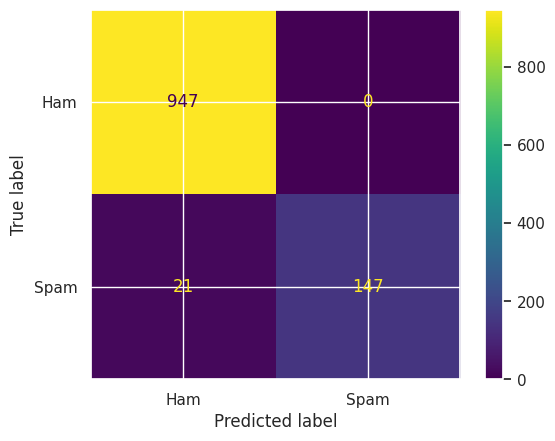

In [84]:
cm_test_svc = metrics.confusion_matrix(ytest_encoded, test_pred_svc)

print('Confusion Matrix for Testing Data : ')
cm_test_svc = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test_svc, display_labels=['Ham', 'Spam'])

cm_test_svc.plot()
plt.show()

**RandomForest Classifier**

In [91]:
# # Initialize the Naive Bayes classifier
RF_model = RandomForestClassifier()

# Define hyperparameter grid for Grid Search
params = {
    'n_estimators': [250, 500],
    'max_depth': [None, 10, 20],
}

# Create a GridSearchCV object with the Random Forest model and parameters
grid_search_rf = GridSearchCV(RF_model, param_grid=params)

# Train the classifier on the training data
grid_search_rf.fit(xtrain_tfidf, ytrain_encoded)

# Get the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

# Predict the labels for the train and test data
train_pred_rf = best_rf_model.predict(xtrain_tfidf)
test_pred_rf = best_rf_model.predict(xtest_tfidf)

# Evaluate the accuracy of the classifier
train_accuracy_rf = metrics.accuracy_score(ytrain_encoded, train_pred_rf)
test_accuracy_rf = metrics.accuracy_score(ytest_encoded, test_pred_rf)

print(f"Training Accuracy: {np.round(train_accuracy_rf, 3)*100} %")
print(f"Testing Accuracy: {np.round(test_accuracy_rf, 2)*100} %")

Training Accuracy: 100.0 %
Testing Accuracy: 98.0 %


In [92]:
best_rf_model

RandomForestClassifier(n_estimators=250)

In [93]:
# Print classification report for Testing
print("Classification Report For Testing:")
print(metrics.classification_report(ytest_encoded, test_pred_rf))

Classification Report For Testing:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       947
           1       1.00      0.85      0.92       168

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



**Confusion Matrix**

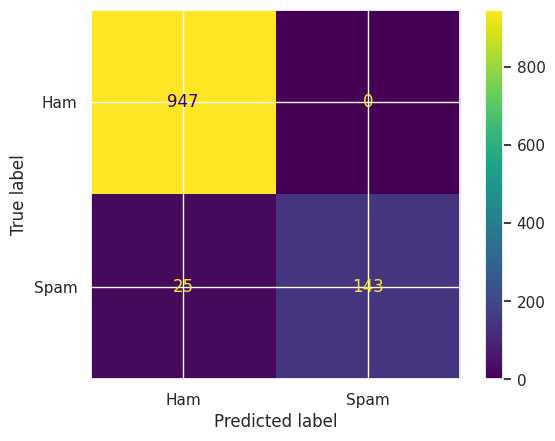

In [94]:
cm_test_rf = metrics.confusion_matrix(ytest_encoded, test_pred_rf)
cm_test_rf = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test_rf, display_labels=['Ham', 'Spam'])

cm_test_rf.plot()
plt.show()

### **Conclusion**

* **The Support Vector Machine classifier** demonstrates superior performance, achieving a high training accuracy of **99%** and a commendable testing accuracy of **98%**. Furthermore, its precision, recall, and F1-scores for both classes on both the training and testing datasets are consistently high, indicating robust performance across the board. Therefore, based on these evaluation metrics, we can confidently conclude that the SVC classifier outperforms other models and is the best choice for this classification task.*

**Classification Report**

-  The SVC model demonstrates excellent performance in classifying ham messages, achieving high precision, recall, and F1-score. However, it shows slightly lower recall for spam messages, indicating that there is room for improvement in identifying all spam messages correctly. Overall, with an accuracy of 98%, the SVC model effectively distinguishes between ham and spam messages, making it a reliable choice for spam detection tasks.

**Confustion Matrix**

- SVC model is performing well in correctly identifying ham messages (class 0), with 947 instances correctly classified as ham and none incorrectly classified as spam. However, for spam messages (class 1), there are 21 instances incorrectly classified as ham and 147 instances correctly classified as spam.

- From this confusion matrix, we can see that the model is not failing to identify spam messages correctly (i.e., it is not classifying ham as spam). Instead, it is missing some spam messages, leading to false negatives. The model is performing well in identifying ham messages.

### **Building a Pipeline**

---



In [103]:
from sklearn.pipeline import Pipeline

In [110]:
# Create a pipeline with TF-IDF vectorizer and SVC model

svm_pipeline = Pipeline([('vect', tfidf_vec), ('clf', SVC(probability=True))])

In [111]:
# Fit the SVM pipeline on the training data

svm_pipeline.fit(xtrain, ytrain_encoded)

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', SVC(probability=True))])

In [112]:
# Predict class probabilities for the test data using the SVM pipeline

prediction_probability = svm_pipeline.predict_proba(xtest)

In [113]:
prediction_probability

array([[9.94181207e-01, 5.81879285e-03],
       [9.84400214e-01, 1.55997857e-02],
       [9.99738574e-01, 2.61426338e-04],
       ...,
       [9.91053332e-01, 8.94666765e-03],
       [9.96751086e-01, 3.24891414e-03],
       [2.78527983e-10, 1.00000000e+00]])

In [129]:
# Predict class labels for the test data using the SVM pipeline

prediction_labels = svm_pipeline.predict(xtest)

In [130]:
# Convert the predicted class labels to their original categorical form using label encoding

prediction_labels = label_encoder.inverse_transform(prediction_labels)

In [119]:
print(f'Model Accuracy for the Train set: {svm_pipeline.score(xtrain, ytrain_encoded)}\n')

print(f'Model Accuracy for the Train set: {svm_pipeline.score(xtest, ytest_encoded)}\n')

Model Accuracy for the Train set: 0.9966345075162666

Model Accuracy for the Train set: 0.9811659192825112



**Creating a dataframe containing the test data along with the predictions made by the model for comparison**

In [121]:
evaluation_df = pd.DataFrame({'Message': xtest, 'Actual Label': ytest, 'Predicted Label': prediction_labels})
evaluation_df.head(10)

,Message,Actual Label,Predicted Label
4004,somewhere beneath pale moon light someone thin...,ham,ham
2276,telly brdget jones,ham,ham
4498,ok,ham,ham
3755,bloomberg message center wait apply future htt...,spam,spam
111,plural noun research,ham,ham
3662,well great weekend,ham,ham
4282,wn u r hurt prsn close u fight wit dem coz som...,ham,ham
1991,hi darlin ive got back really nice night thank...,ham,ham
2298,draw va dont think,ham,ham
2438,ur chance win cash every wk txt play t c www m...,spam,spam


### **Saving the Model and Pipeline**

In [139]:
import pickle

# Save TF-IDF vectorizer to a file
with open('TF_IDF_vec', 'wb') as file:
    pickle.dump(tfidf_vec, file)


# Save the Spam Detection Model (Random Forest classifier) to a file
with open('Spam_Detection_Pipeline', 'wb') as file1:
    pickle.dump(svm_pipeline, file1)

### **Testing**

In [140]:
with open('Spam_Detection_Pipeline', 'rb') as file:
  loaded_pipeline = pickle.load(file)

In [162]:
testing_samples = [
    "Hey, just checking in to see how you're doing.",
    "Could you please send me the report by EOD?",
    "You've won a Free vacation to Hawaii! Call Us to redeem your Prize",
    "Reminder: Meeting at 3 PM today in Conference Room B.",
    "Don't forget to pick up milk on your way home.",
    "Claim your prize by responding to this message within 24 hours.",
]

In [163]:
predictions = loaded_pipeline.predict(testing_samples)
prediction_labels = label_encoder.inverse_transform(predictions)
prediction_labels

array(['ham', 'ham', 'spam', 'ham', 'ham', 'spam'], dtype=object)

In [165]:
pd.DataFrame({
    'Messages': testing_samples,
    'Predictions': prediction_labels
})

,Messages,Predictions
0,"Hey, just checking in to see how you're doing.",ham
1,Could you please send me the report by EOD?,ham
2,You've won a Free vacation to Hawaii! Call Us ...,spam
3,Reminder: Meeting at 3 PM today in Conference ...,ham
4,Don't forget to pick up milk on your way home.,ham
5,Claim your prize by responding to this message...,spam
